In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 
warnings.simplefilter(action='ignore', category=RuntimeWarning) 

# Visualization and calculation tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot import plot_association, plot_feature_importance, box_plot, plot_feature_cross_target
import seaborn as sns
# Stats tools
import scipy.stats as ss
from stats import correlation_ratio, association_test, compute_association_cat_num

from sklearn.model_selection import train_test_split

In [3]:
data=pd.read_csv("./data/cleaned_data/processed_data.csv")
print(data.shape)
data.head(2)

(8180, 9)


,id_men,culture_label,production_kg,superficie,taille_menage,age,nbre_heure_travail,lat,lng
0,1,Arachide,1500,3.0,15,50,28,14.36715,-16.441645
1,1,Mais,500,1.0,15,50,28,14.36715,-16.441645


# Correlations and association magnitude

## Correlation between numerical variables

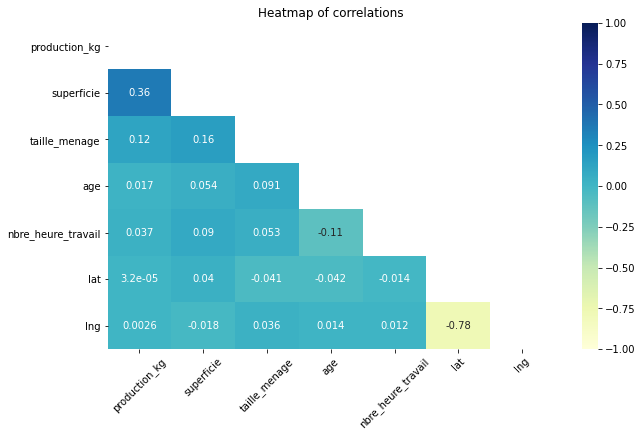

In [4]:
temporary=data[["production_kg", "superficie", "taille_menage", "age", "nbre_heure_travail", "lat", "lng"]]
correlation=temporary.corr(method="pearson")
plot_association(correlation, "correlations")

`production_kg` seems to be more correlated to the area of the farm (`superficie`), which is understandable. The land coordinates `lat`and `lng` seem also to be quite correlated with each other.

## Association degree between the culture label and the numerical variables

First we introduce a new variable `log_production_kg` the logarithm of the production which dampens the production and is meant for visualisation purpose.

In [5]:
data["log_production_kg"]=np.log10(data["production_kg"])

In [6]:
top10_cultures=data["culture_label"].value_counts().sort_values(ascending=False)[:10]
top10_cultures

Arachide    2461
Mil         2121
Mais        1194
Niebe        779
Riz          702
Sorgho       553
Pasteque      88
Sesame        73
Bissap        57
Manioc        36
Name: culture_label, dtype: int64

In [7]:
print("The above cultures make up %i percent of the data"
      % (100*top10_cultures.sum()/len(data))
     )

The above cultures make up 98 percent of the data


As a result we decide to drop the underrepresented cultures

In [8]:
data.drop(index=data[~data["culture_label"].isin(top10_cultures.index)].index, inplace=True)

In [9]:
data.shape

(8064, 10)

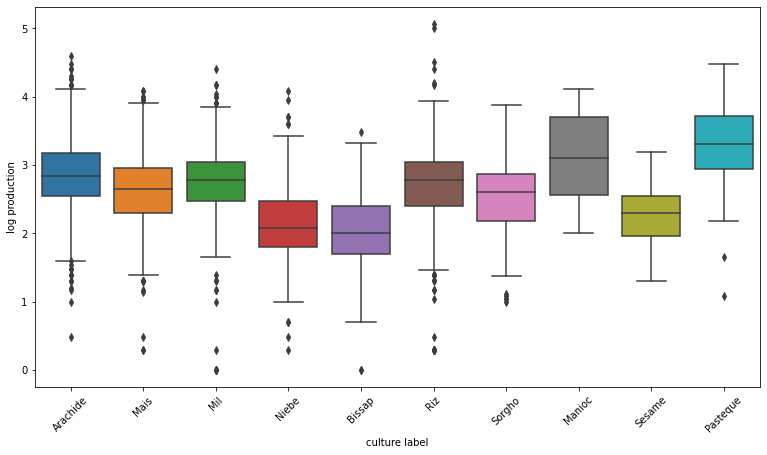

In [10]:
box_plot(data, x="culture_label", y="log_production_kg", xlabel="culture label", ylabel="log production")

It seems there is some significant relation between the production and the type of culture. Let us try to use some statistical tools to decide: **correlation ratio** between `culture_label` and `production_kg`.

In [11]:
print("Correlation ratio of : {} %"
      .format(100*round(correlation_ratio(data["culture_label"], np.array(data["production_kg"])), 2))
     )

Correlation ratio of : 5.0 %


But is it significant ? --> Using **Analysis of Variance** or similar tests

In [12]:
production_per_category=\
([
    data[data["culture_label"]==label]["production_kg"] 
    for label in data['culture_label'].unique()
])

In [13]:
print(association_test(production_per_category)+'\n'+\
      association_test(production_per_category, test_type="Kruskal Wallis")
     )

The ANOVA test rejects the equality of means at level 0.05
The Kruskal Wallis test rejects the equality of medians at level 0.05


As a result it seems there is a significant relation between `production_kg` and `culture_label`. Let us compute the correlation ratio between the numerical features and the type of culture, along wiith the pvalues of the ANOVA test

In [14]:
num_cols=data.drop(columns=["id_men", "log_production_kg", "culture_label"]).columns
cat_cols=["culture_label"]
association, pvalue=compute_association_cat_num(data, num_cols, cat_cols)
association.head(2) 

,culture_label
production_kg,0.048917
superficie,0.083132


In [15]:
pvalue.head(2)

,culture_label
production_kg,1.811667e-81
superficie,9.692859e-145


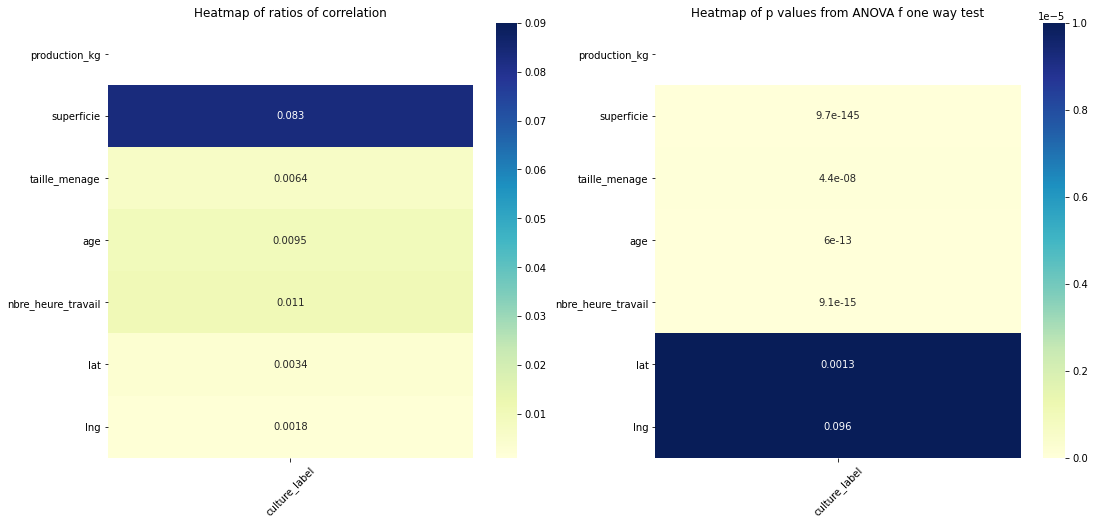

In [16]:
f, ax = plt.subplots(1,2, figsize=(18, 8))
plot_association(association, "ratios of correlation", vmin=0.001, vmax=0.09, ax=ax[0])
plot_association(pvalue, "p values from ANOVA f one way test",  vmin=0, vmax=10**(-5) , ax=ax[1])

It seems there is a significant association degree between the numerical features and the culture type.

# Some further descriptions of the data: feature cross target

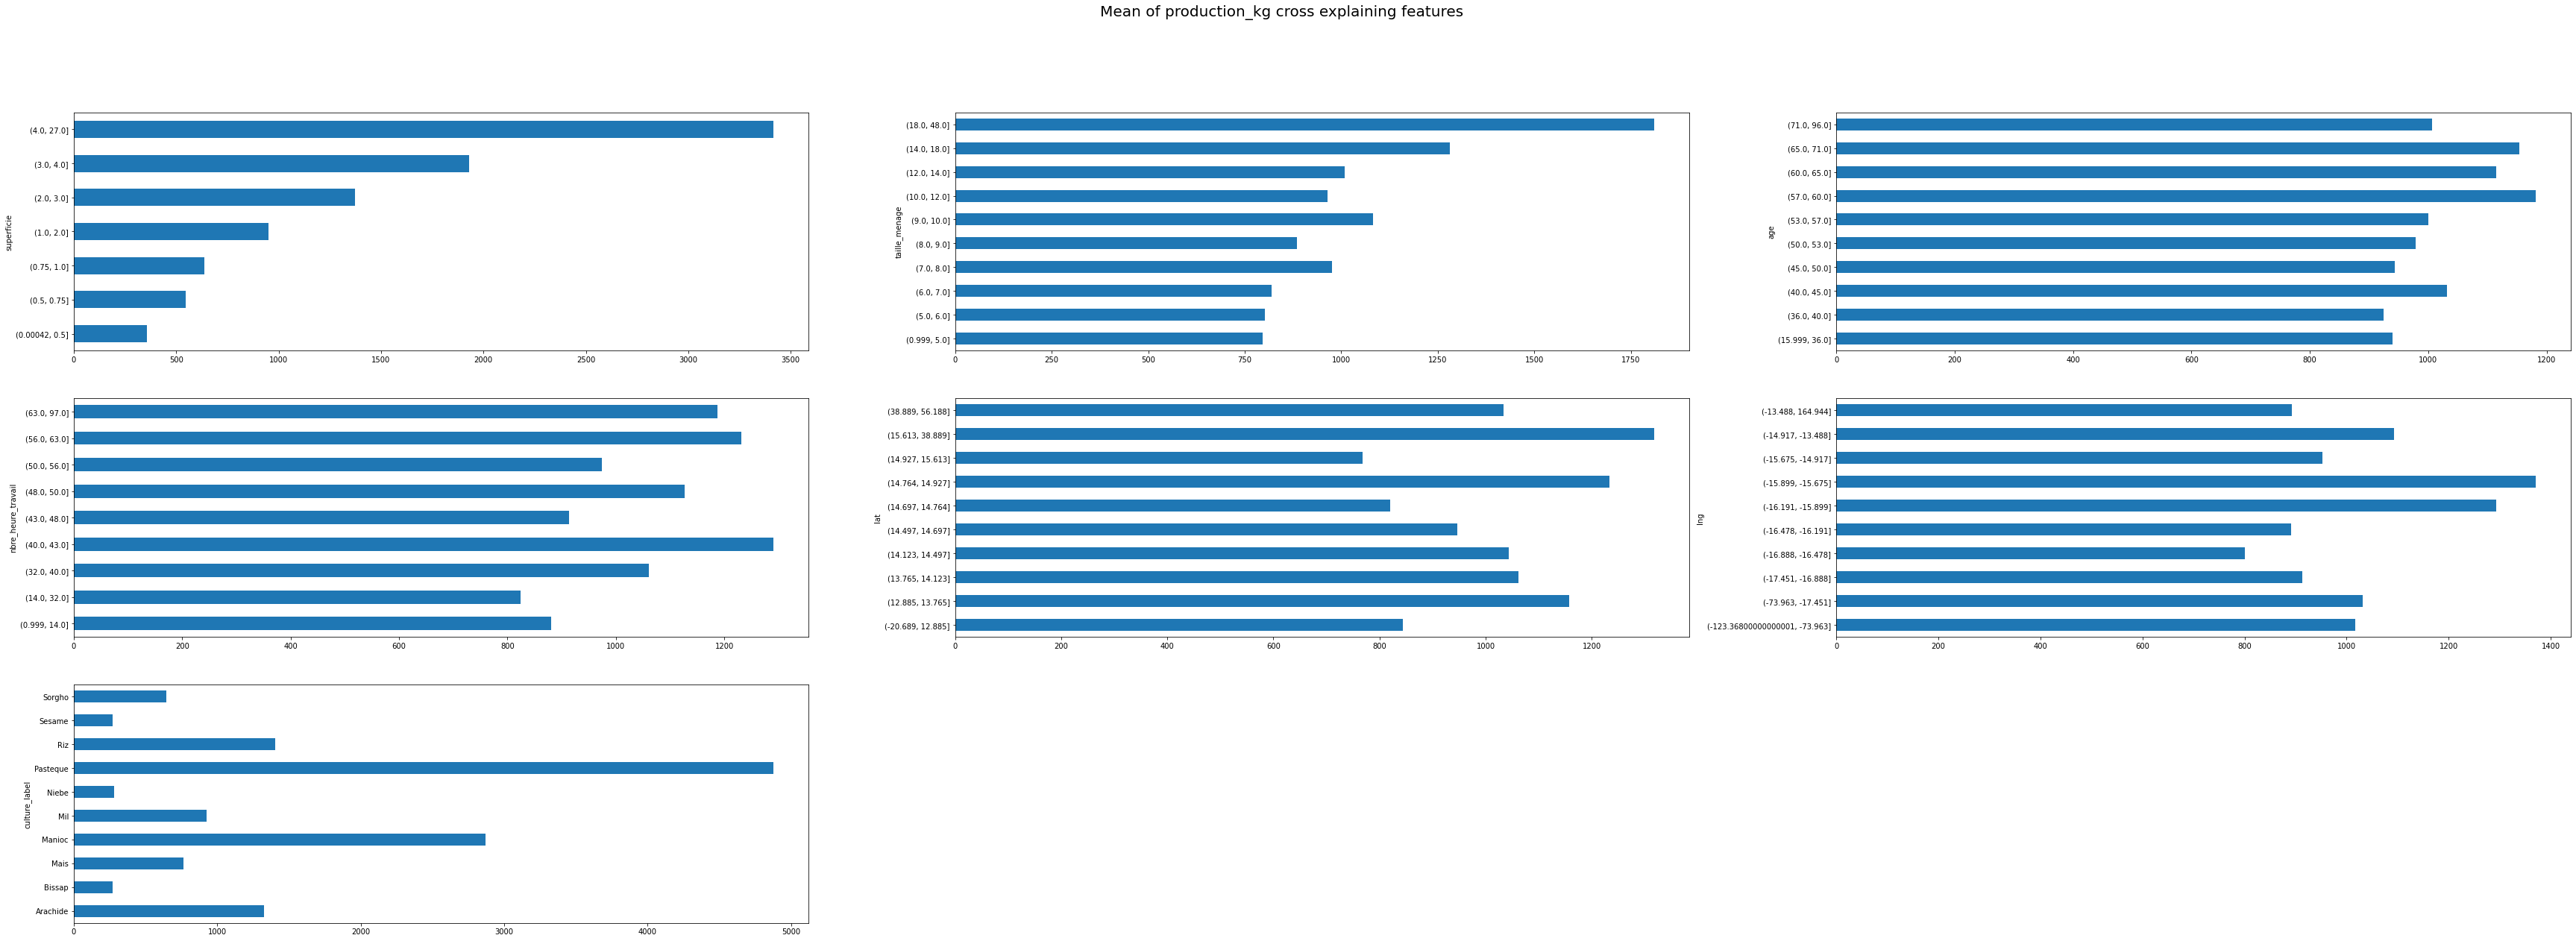

In [20]:
num_features=list(data.drop(columns=["id_men", "log_production_kg","culture_label", "production_kg"]).columns)
plot_feature_cross_target(data, num_feat=num_features, \
                          target="production_kg", cat_feat=["culture_label"],\
                         figsize=(60,20), n_col=3, fontsize=20)

# Saving data for modelling purpose

In [21]:
data.drop(columns=["id_men", "log_production_kg"], inplace=True)
data=pd.get_dummies(data, columns=['culture_label'])
data.head(2)

,production_kg,superficie,taille_menage,age,nbre_heure_travail,lat,lng,culture_label_Arachide,culture_label_Bissap,culture_label_Mais,culture_label_Manioc,culture_label_Mil,culture_label_Niebe,culture_label_Pasteque,culture_label_Riz,culture_label_Sesame,culture_label_Sorgho
0,1500,3.0,15,50,28,14.36715,-16.441645,1,0,0,0,0,0,0,0,0,0
1,500,1.0,15,50,28,14.36715,-16.441645,0,0,1,0,0,0,0,0,0,0


In [22]:
data.to_csv("./data/model_data/data_with_dummies.csv", index=False)

# Lightly modelling the production

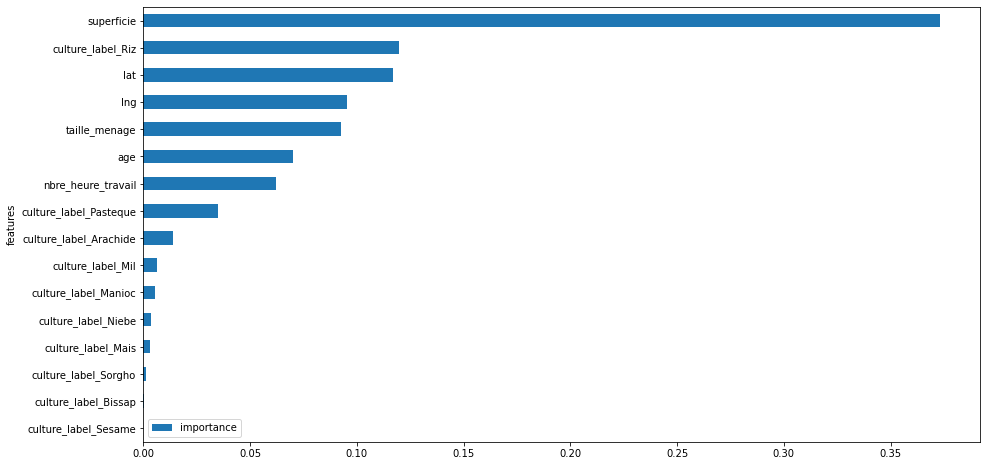

In [23]:
plot_feature_importance(X=data.drop(columns=['production_kg']), Y=data["production_kg"])

It seems `superficie` (the area) is the most important feature. But we will tune different models in the modelling notebook to have maybe a better understanding of what is going on. 

# Splitting the data for modelling purpose

In [24]:
train, test=train_test_split(data)

In [25]:
train.to_csv("./data/model_data/train.csv", index=False); test.to_csv("./data/model_data/test.csv", index=False)